In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- 1) FILE LIST (all 23) ----------------
YEAR = 2024
# (machine) : (path, value_column, units)
MANIFEST = {
    # ----- EPI (kW) -----
    "EPI_ChipPress":      (fr"dataset_clean\EPI_ChipPress\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_ChipSaw":        (fr"dataset_clean\EPI_ChipSaw\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_PickAndPlace":   (fr"dataset_clean\EPI_PickAndPlace\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_PumpStation1":   (fr"dataset_clean\EPI_PumpStation1\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_PumpStation2":   (fr"dataset_clean\EPI_PumpStation2\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_ScreenPrinter":  (fr"dataset_clean\EPI_ScreenPrinter\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_SolderOven":     (fr"dataset_clean\EPI_SolderOven\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_TotalLoad":      (fr"dataset_clean\EPI_TotalLoad\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_VacuumSoldering":(fr"dataset_clean\EPI_VacuumSoldering\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_WashingMachine": (fr"dataset_clean\EPI_WashingMachine\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),
    "EPI_HighTempOven":   (fr"dataset_clean\EPI_HighTempOven\P_total\{YEAR}_P_total.csv.xz", "P_total", "kW"),

    # ----- TEC (W -> kW) -----
    "TEC_48S":        (fr"dataset_clean\TEC_48S\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_CFST161":    (fr"dataset_clean\TEC_CFST161\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_CTX800TC":   (fr"dataset_clean\TEC_CTX800TC\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_Chiron800":  (fr"dataset_clean\TEC_Chiron800\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_DMF3008":    (fr"dataset_clean\TEC_DMF3008\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_DMU125MB":   (fr"dataset_clean\TEC_DMU125MB\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_DNG50evo":   (fr"dataset_clean\TEC_DNG50evo\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_E110":       (fr"dataset_clean\TEC_E110\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_E30D2":      (fr"dataset_clean\TEC_E30D2\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_JWA24":      (fr"dataset_clean\TEC_JWA24\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),
    "TEC_MV2400R":    (fr"dataset_clean\TEC_MV2400R\P_total\{YEAR}_P_total.csv.xz", "P_total", "W"),

    # ----- PV (W -> kW) -----
    "IPE_PV":         (fr"dataset_clean\IPE_PV\AC_ActivePower\{YEAR}_AC_ActivePower.csv.xz", "AC_ActivePower", "W"),
}

# ---------------- 2) LOAD ALL TO 1-MIN DF ----------------
def load_series(path, value_col, units):
    if not Path(path).exists():
        return None
    df = pd.read_csv(path, usecols=["WsDateTime", value_col], parse_dates=["WsDateTime"])
    df = df.set_index("WsDateTime").sort_index()
    s = df[value_col]
    if units.lower() == "w":
        s = s / 1000.0  # -> kW
    s = s.resample("1min").mean()
    return s

series = {}
for machine, (p, col, unit) in MANIFEST.items():
    s = load_series(p, col, unit)
    if s is not None:
        series[machine] = s

df_1min = pd.DataFrame(series).sort_index()  # one DataFrame with all machines at 1-min (kW)


# ---------------- EXAMPLES ----------------
# 1) One global start for all machines:
#plot_week_stacked(df_1min, start_global="2024-01-01", days=7)

# 2) Per-machine manual starts (override a few; others fall back to global):
# starts = {
#     "EPI_TotalLoad": "2024-01-04",
#     "TEC_Chiron800": "2024-01-03",
#     "IPE_PV": "2024-05-10",
# }
# plot_week_stacked(df_1min, start_global="2024-01-01", starts_per_machine=starts, days=7)


In [2]:
# ---------------- 3) PLOTTING WITH MANUAL STARTS ----------------
def plot_week_stacked(df, start_global=None, starts_per_machine=None, days=7, center_around_zero=True):
    """
    - start_global: Timestamp/str for all machines (e.g. '2024-01-01')
    - starts_per_machine: dict {machine: Timestamp/str} to override per machine
    - days: window length (default 7)
    - center_around_zero: subtract midpoint ((min+max)/2) and set symmetric y-lims
    """
    if isinstance(start_global, str):
        start_global = pd.Timestamp(start_global)
    if starts_per_machine:
        starts_per_machine = {k: (pd.Timestamp(v) if isinstance(v, str) else v)
                              for k, v in starts_per_machine.items()}

    machines = [m for m in df.columns if df[m].notna().any()]
    n = len(machines)
    fig, axes = plt.subplots(n, 1, figsize=(14, 2*n), sharex=False)
    if n == 1:
        axes = [axes]

    for ax, m in zip(axes, machines):
        start = starts_per_machine.get(m, start_global) if starts_per_machine else start_global
        if start is None:
            # if no start provided, use the first timestamp with data for that machine
            first = df[m].first_valid_index()
            if first is None:
                continue
            start = first
        end = start + pd.Timedelta(days=days)

        s = df[m].loc[start:end]
        if s.empty:
            ax.set_ylabel(m, rotation=0, ha="right", va="center", labelpad=18)
            ax.text(0.01, 0.5, "no data in window", transform=ax.transAxes)
            ax.grid(True, alpha=0.3)
            continue

        if center_around_zero:
            mn, mx = s.min(), s.max()
            mid = (mn + mx) / 2.0
            s_center = s - mid
            ax.plot(s_center.index, s_center.values, lw=1.0)
            span = max(abs(s_center.min()), abs(s_center.max()))
            ax.set_ylim(-span, span)
            ax.axhline(0.0, lw=0.8, alpha=0.5)
        else:
            ax.plot(s.index, s.values, lw=1.0)

        ax.set_ylabel(m, rotation=0, ha="right", va="center", labelpad=18)
        ax.grid(True, alpha=0.3)
        ax.set_title(f"{m}: {start} → {end}")

    plt.tight_layout()
    #fig.suptitle(f"Power (kW) — 1-minute — {days}-day windows (centered around zero)", y=1.02)
    plt.show()

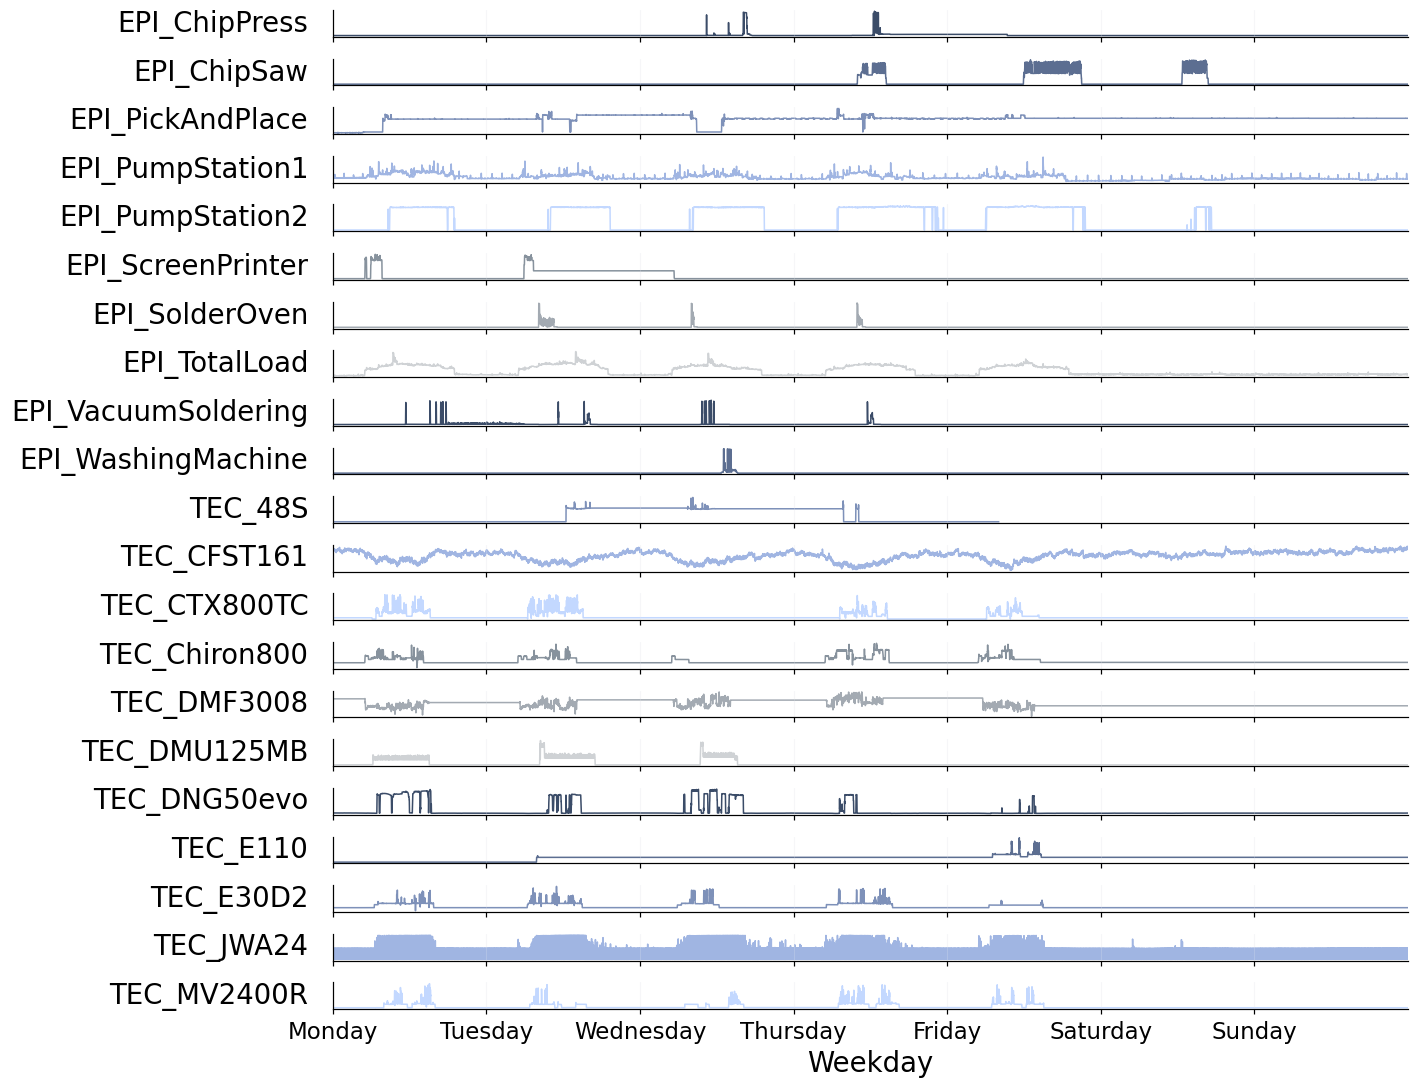

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# ---- custom color palette (your colors) ----
colors = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2",
          "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

# ---- 1) Per-machine week offsets (0=first Monday-aligned week, 1=skip 1 week, …) ----
week_offsets = {
    # EPI (11)
    "EPI_ChipPress": 32,
    "EPI_ChipSaw": 6,
    "EPI_PickAndPlace": 2,
    "EPI_PumpStation1": 1,
    "EPI_PumpStation2": 4,
    "EPI_ScreenPrinter": 20,
    "EPI_SolderOven": 2,
    "EPI_TotalLoad": 1,
    "EPI_VacuumSoldering": 11,
    "EPI_WashingMachine": 4,
    "EPI_HighTempOven": 0,

    # TEC (11)
    "TEC_48S": 3,
    "TEC_CFST161": 2,
    "TEC_CTX800TC": 2,
    "TEC_Chiron800": 2,
    "TEC_DMF3008": 2,
    "TEC_DMU125MB": 2,
    "TEC_DNG50evo": 2,
    "TEC_E110": 2,
    "TEC_E30D2": 2,
    "TEC_JWA24": 2,
    "TEC_MV2400R": 2,

    # PV (1)
    "IPE_PV": 5,
}

# ---- 2) Monday-aligned starts from offsets ----
def build_starts_from_offsets(df_1min: pd.DataFrame, week_offsets: dict) -> dict:
    starts = {}
    for m, off in week_offsets.items():
        if m not in df_1min.columns:
            continue
        first = df_1min[m].first_valid_index()
        if first is None:
            continue
        days_ahead = (7 - first.weekday()) % 7  # 0 if already Monday
        monday = (first + pd.Timedelta(days=days_ahead)).normalize()
        starts[m] = monday + pd.Timedelta(weeks=int(off))
    return starts

# ---- 3) Plot: stacked subplots, shared weekday axis, natural y-scale ----
def plot_week_stacked(df: pd.DataFrame,
                      starts_per_machine: dict,
                      days: int = 7) -> None:
    machines = [m for m in df.columns if m in starts_per_machine]
    if not machines:
        print("No matching machines found in df for the provided starts.")
        return

    n = len(machines)
    
    fig, axes = plt.subplots(n, 1, figsize=(13, 10), sharex=True)
    if n == 1:
        axes = [axes]

    # Styling
    plt.rcParams.update({
        "axes.labelsize": 18,
        "axes.titlesize": 18,
        "xtick.labelsize": 13,
        "ytick.labelsize": 18,
        "figure.dpi": 110,
    })

    # Common reference Monday so all subplots share the same x-limits
    ref0 = pd.Timestamp("2024-01-01")  # Monday
    day_edges = [ref0 + pd.Timedelta(days=d) for d in range(days + 1)]
    day_centers = [ref0 + pd.Timedelta(days=d) for d in range(days)]
    weekday_labels = [(ref0 + pd.Timedelta(days=d)).strftime("%A") for d in range(days)]

    for i, (ax, m) in enumerate(zip(axes, machines)):
        start = starts_per_machine[m]
        end = start + pd.Timedelta(days=days)
        s = df[m].loc[start:end - pd.Timedelta(minutes=1)].dropna()

        if s.empty:
            ax.text(0.01, 0.5, "no data in window", transform=ax.transAxes,
                    va="center", ha="left")
            ax.set_ylabel(m, rotation=0, ha="right", va="center", labelpad=16)
            ax.set_yticks([])
            ax.grid(True, axis="x", alpha=0.2)
            continue

        s_ref = s.copy()
        s_ref.index = ref0 + (s.index - start)

        color = colors[i % len(colors)]
        ax.plot(s_ref.index, s_ref.values, lw=1.0, color=color)
        ax.set_ylabel(m, rotation=0, ha="right", va="center", labelpad=16)

        ax.set_yticks([])
        for x in day_edges:
            ax.axvline(x, lw=0.6, alpha=0.25, color="#e6e9ef")
        ax.grid(True, axis="x", alpha=0.15, color="#e6e9ef")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        if i < n - 1:
            ax.tick_params(axis="x", which="both", labelbottom=False)

    axes[-1].set_xlim(day_edges[0], day_edges[-1])
    axes[-1].set_xticks(day_centers)
    axes[-1].set_xticklabels(weekday_labels)
    axes[-1].xaxis.set_major_formatter(DateFormatter("%A"))
    axes[-1].set_xlabel("Weekday")

    plt.tight_layout()
    plt.savefig("01Figures/Fig_Energy_Profiles.pdf", bbox_inches="tight")
    plt.show()

# ---- 4) Use it ----
# df_1min must already exist with 1-minute resolution columns for each machine.
starts = build_starts_from_offsets(df_1min, week_offsets)
plot_week_stacked(df_1min, starts_per_machine=starts, days=7)
